In [ ]:
import networkx as nx
import pickle

with open("../data/processed/traffic_graph.pkl", "rb") as f:
    G = pickle.load(f)


In [ ]:
import networkx as nx
import math

# Step 1: Find all connected components
components = list(nx.weakly_connected_components(G))

# Step 2: Identify the largest component (assumed to be the main graph)
largest_component = max(components, key=len)
main_graph_nodes = set(largest_component)

# Step 3: Find nodes outside the main graph (disconnected)
isolated_nodes = [node for component in components if component != largest_component for node in component]

print(f"Number of isolated nodes: {len(isolated_nodes)}")

# Step 4: Connect each isolated node to its nearest main graph node
def euclidean_dist(n1, n2):
    x1, y1 = G.nodes[n1]['x'], G.nodes[n1]['y']
    x2, y2 = G.nodes[n2]['x'], G.nodes[n2]['y']
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)

for iso_node in isolated_nodes:
    # Find the closest node in the main graph
    min_dist = float('inf')
    closest_node = None
    for main_node in main_graph_nodes:
        try:
            dist = euclidean_dist(iso_node, main_node)
            if dist < min_dist:
                min_dist = dist
                closest_node = main_node
        except KeyError:
            continue  # Skip if coordinates are missing
    # if closest_node:
    #     # Add edge (you can add attributes like length here if needed)
    #     G.add_edge(iso_node, closest_node, length=min_dist)
    #     print(f"Connected {iso_node} to {closest_node} with distance {min_dist:.2f}")


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Assume G is your directed graph
# Use weakly connected components to find isolated nodes
components = list(nx.weakly_connected_components(G))

# Step 2: The largest component is typically the main connected graph
largest_component = max(components, key=len)

# Step 3: Separate nodes into connected and isolated groups
connected_nodes = largest_component
isolated_nodes = set(G.nodes()) - connected_nodes

# Step 4: Draw the full graph with different colors
pos = nx.spring_layout(G, seed=42)  # or use your own lat/lon layout

# Draw connected nodes
nx.draw_networkx_nodes(G, pos,
                       nodelist=connected_nodes,
                       node_color='lightgreen',
                       label='Connected')

# Draw isolated nodes
nx.draw_networkx_nodes(G, pos,
                       nodelist=isolated_nodes,
                       node_color='red',
                       label='Isolated')

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.3)

# Optional: Add legend
plt.legend(scatterpoints=1)
plt.title("Graph with Isolated vs Connected Nodes")
plt.axis('off')
plt.show()


In [6]:
import pandas as pd
import networkx as nx

# Load your edge list and create the graph
edges_df = pd.read_csv("../data/processed/subset_edges.csv")
G = nx.from_pandas_edgelist(edges_df, source='u', target='v', create_using=nx.Graph())


In [7]:
# Identify the largest connected component
components = list(nx.connected_components(G))
components = sorted(components, key=len, reverse=True)

# The largest component
main_component = components[0]
main_nodes = set(main_component)

# Isolated or small-component nodes (not in main)
isolated_nodes = [node for comp in components[1:] for node in comp]


In [9]:
from geopy.distance import geodesic

# Load node positions (you must have lat/lon data)
nodes_df = pd.read_csv("../data/processed/subset_nodes.csv")  # Replace with actual node file

# Build a lookup table for coordinates
coord_dict = nodes_df.set_index('osmid')[['y', 'x']].to_dict('index')

new_edges = []

for node in isolated_nodes:
    node_coord = coord_dict.get(node)
    if not node_coord:
        continue

    # Find the nearest node in main component
    min_dist = float("inf")
    nearest_node = None

    for target in main_nodes:
        target_coord = coord_dict.get(target)
        if not target_coord:
            continue

        dist = geodesic((node_coord['y'], node_coord['x']),
                        (target_coord['y'], target_coord['x'])).meters
        if dist < min_dist:
            min_dist = dist
            nearest_node = target

    if nearest_node:
        new_edges.append({
            'u': node,
            'v': nearest_node,
            'artificial': True
        })


In [10]:
edges_df['artificial'] = False

In [11]:
new_edges_df = pd.DataFrame(new_edges)
combined_edges_df = pd.concat([edges_df, new_edges_df], ignore_index=True)

# Save to new file
combined_edges_df.to_csv("../data/processed/subset_connected_edges.csv", index=False)


In [16]:
# Load nodes and edges
nodes_df = pd.read_csv("../data/processed/subset_nodes.csv")
edges_df = pd.read_csv("../data/processed/subset_connected_edges.csv")


In [17]:
# Create an undirected graph
G = nx.Graph()

# Add nodes with position attributes
for _, row in nodes_df.iterrows():
    G.add_node(row['osmid'], x=row['x'], y=row['y'])

# Add edges with metadata
for _, row in edges_df.iterrows():
    G.add_edge(
        row['u'], 
        row['v'], 
        real=row['artificial'],  # Assumes 'real' column exists with True/False
        length=row.get('length', None), 
        name=row.get('name', None)
    )


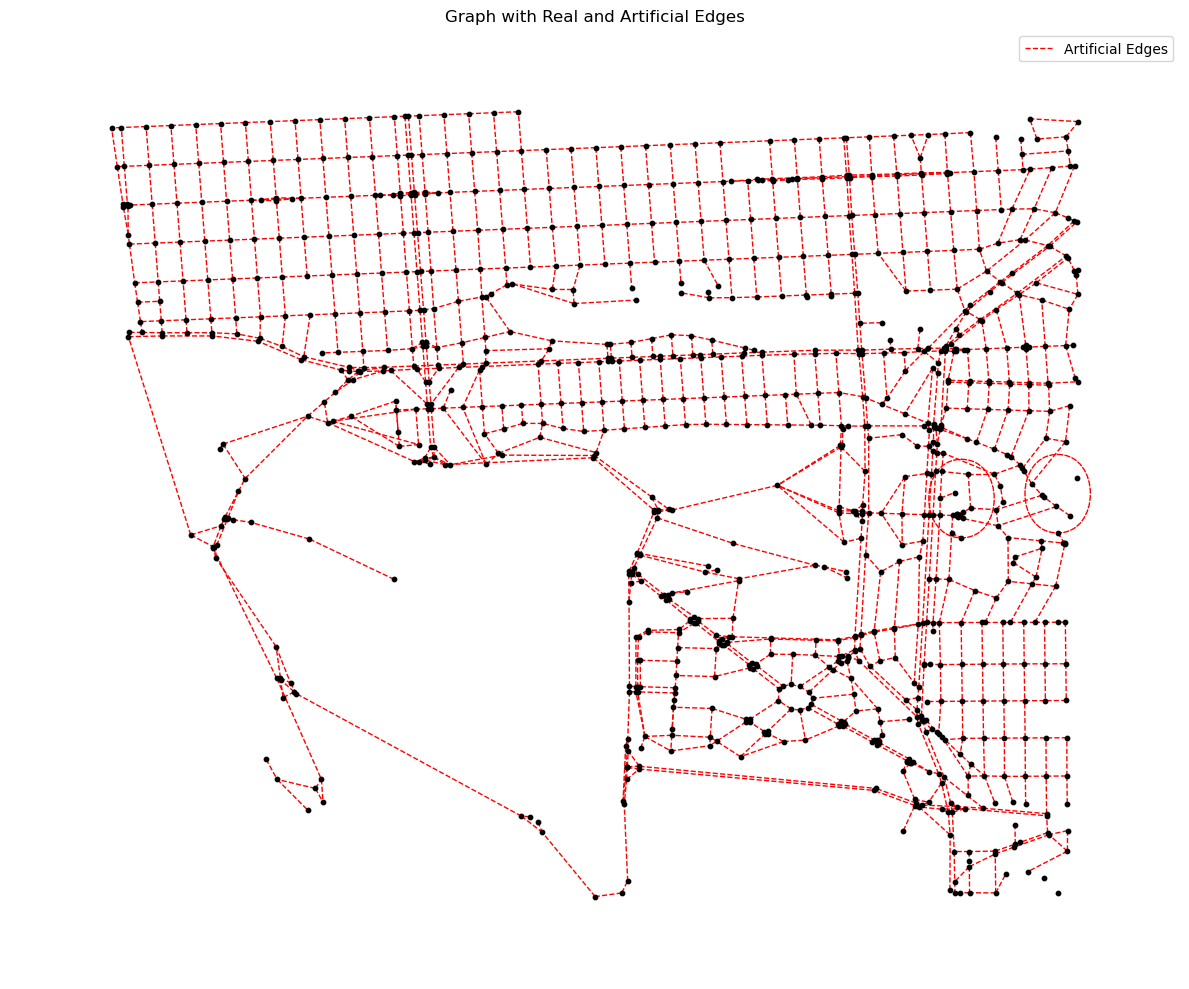

In [19]:
# Get positions for plotting
pos = {node: (data['x'], data['y']) for node, data in G.nodes(data=True)}

# Separate edges
real_edges = [(u, v) for u, v, d in G.edges(data=True) if d.get('artificial', False)]
artificial_edges = [(u, v) for u, v, d in G.edges(data=True) if not d.get('artificial', False)]

plt.figure(figsize=(12, 10))


scale_factor = 1000
pos = {node: (data['x'] * scale_factor, data['y'] * scale_factor) for node, data in G.nodes(data=True)}

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=10, node_color="black")

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=real_edges, edge_color="blue", width=1, label="Real Edges")
nx.draw_networkx_edges(G, pos, edgelist=artificial_edges, edge_color="red", width=1, style='dashed', label="Artificial Edges")

plt.legend()
plt.title("Graph with Real and Artificial Edges")
plt.axis("off")
plt.tight_layout()
plt.show()
